In [37]:
from ultralytics import YOLO
import os
import torch
import glob
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.optim as optim
import plot
import distance_estimation
import utils
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from time import time

In [38]:
device = torch.device("cpu")      # "cuda" if torch.cuda.is_available() else 
robot_height = 0.545 # m
torch.manual_seed(0)

In [39]:
device

device(type='cpu')

In [40]:
ROOT = '/media/hariharan/ULINDU/Ulindu/turtlebot_detection/csv_data/Spherical_Coordinate/'

In [41]:
path_dir = os.listdir(ROOT)

In [42]:
path_dir

['Corridor_2024-02-06-21-34-18.txt',
 'Corridor_2024-02-06-21-40-49.txt',
 'Level1_2024-02-20-16-34-57.txt',
 'Level1_2024-02-20-16-44-28.txt',
 'Level1_Enhanced_2024-03-12-14-30-14.txt',
 'Level1_Enhanced_2024-03-12-14-50-28.txt',
 'Level1_Straight_Line_2024-03-01-17-27-00.csv',
 'with_predictions']

In [43]:
# first_floor_day2 = pd.read_csv(ROOT + path_dir[6])
# first_floor_other_than_day2 = pd.read_csv(ROOT + path_dir[7])
corridor_set1_df = pd.read_csv(ROOT + path_dir[0], sep = ' ')
corridor_set2_df = pd.read_csv(ROOT + path_dir[1], sep = ' ')
first_floor_day1_set1_df = pd.read_csv(ROOT + path_dir[2], sep = ' ')
first_floor_day1_set2_df = pd.read_csv(ROOT + path_dir[3], sep = ' ')
first_floor_day2_set1_df = pd.read_csv(ROOT + path_dir[4], sep = ' ')
first_floor_day2_set2_df = pd.read_csv(ROOT + path_dir[5], sep = ' ')
first_floor_straight_line = pd.read_csv(ROOT + path_dir[6], sep = ',')
# set1 = pd.read_csv(ROOT + path_dir[8])
# set2 = pd.read_csv(ROOT + path_dir[9])

In [44]:
first_floor_straight_line

,filename,gt_x,gt_y,gt_heading,x1,y1,x2,y2,X1,Y1,...,Z3,X4,Y4,Z4,u,v,w,h,abs_dist,angle
0,1709285220.494589_F.jpg,1.000000,0.000000,0.000000,1425.9,1577.9,1642.4,1871.2,-0.021871,0.186663,...,0.856941,0.226216,0.508453,0.830844,0.532691,0.598802,0.075174,0.101840,1.000000,1.570000
1,1709285221.315454_F.jpg,1.000000,0.000000,0.000000,1426.1,1577.6,1641.3,1871.5,-0.021626,0.186302,...,0.856765,0.224976,0.508823,0.830954,0.532535,0.598802,0.074722,0.102049,1.000000,1.570000
2,1709285222.318004_F.jpg,1.000000,0.000000,0.000000,1426.3,1577.6,1641.8,1872.4,-0.021382,0.186302,...,0.856225,0.225472,0.509685,0.830292,0.532656,0.598958,0.074826,0.102361,1.000000,1.570000
3,1709285223.339444_F.jpg,1.000000,0.000000,0.000000,1426.3,1577.8,1641.8,1872.6,-0.021381,0.186544,...,0.856104,0.225458,0.509883,0.830173,0.532656,0.599028,0.074826,0.102361,1.000000,1.570000
4,1709285224.369081_F.jpg,1.000000,0.000000,0.000000,1425.9,1577.6,1641.9,1872.3,-0.021871,0.186301,...,0.856276,0.225589,0.509579,0.830325,0.532604,0.598941,0.075000,0.102326,1.000000,1.570000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,1709285436.305252_F.jpg,0.880562,0.199261,-0.115017,1380.7,1579.5,1600.7,1885.1,-0.077122,0.188354,...,0.846012,0.178874,0.524701,0.832282,0.517604,0.601493,0.076389,0.106111,0.902826,1.793337
217,1709285437.309666_F.jpg,0.880562,0.199261,-0.115017,1381.0,1579.4,1601.0,1884.4,-0.076757,0.188235,...,0.846468,0.179248,0.523995,0.832646,0.517708,0.601354,0.076389,0.105903,0.902826,1.793337
218,1709285438.332640_F.jpg,0.880562,0.199261,-0.115017,1381.1,1579.3,1601.0,1884.6,-0.076636,0.188116,...,0.846354,0.179237,0.524192,0.832524,0.517726,0.601371,0.076354,0.106007,0.902826,1.793337
219,1709285439.369398_F.jpg,0.880562,0.199261,-0.115017,1380.8,1578.9,1601.0,1884.3,-0.077005,0.187631,...,0.846513,0.179253,0.523896,0.832707,0.517674,0.601250,0.076458,0.106042,0.902826,1.793337


## Preprocessing 

In [45]:
corridor_set1_df = utils.calc_uvwh(corridor_set1_df.dropna())
corridor_set2_df = utils.calc_uvwh(corridor_set2_df.dropna())
first_floor_day1_set1_df = utils.calc_uvwh(first_floor_day1_set1_df.dropna())
first_floor_day1_set2_df = utils.calc_uvwh(first_floor_day1_set2_df.dropna())
first_floor_day2_set1_df = utils.calc_uvwh(first_floor_day2_set1_df.dropna())
first_floor_day2_set2_df = utils.calc_uvwh(first_floor_day2_set2_df.dropna())
first_floor_straight_line = utils.calc_uvwh(first_floor_straight_line.dropna())

/media/hariharan/ULINDU/Ulindu/turtlebot_detection/utils.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['u'][idx] = u
/media/hariharan/ULINDU/Ulindu/turtlebot_detection/utils.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['v'][idx] = v
/media/hariharan/ULINDU/Ulindu/turtlebot_detection/utils.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['w'][idx] = w
/media/hariharan/ULINDU/Ulindu/turtlebot

In [46]:
corridor_set1_df[['u','v','w','h']]=corridor_set1_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
corridor_set2_df[['u','v','w','h']]=corridor_set2_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_day1_set1_df[['u','v','w','h']]=first_floor_day1_set1_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_day1_set2_df[['u','v','w','h']]=first_floor_day1_set2_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_day2_set1_df[['u','v','w','h']]=first_floor_day2_set1_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_day2_set2_df[['u','v','w','h']]=first_floor_day2_set2_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
first_floor_straight_line[['u','v','w','h']]=first_floor_straight_line[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)

In [47]:
corridor_set1_df

,Unnamed: 0,filename,gt_x,gt_y,gt_heading,x1,y1,x2,y2,X1,...,Z3,X4,Y4,Z4,abs_dist,angle,u,v,w,h
0,0,1707226458.206863_F.jpg,1.033080,0.055224,-0.079079,1292.7,1585.5,1554.4,1959.4,-0.183379,...,0.785505,0.123640,0.597624,0.792186,1.034555,1.624201,0.494288,0.615434,0.090868,0.129826
1,1,1707226459.285001_F.jpg,1.035790,0.052962,-0.078711,1292.6,1585.3,1554.5,1959.3,-0.183503,...,0.785554,0.123755,0.597528,0.792241,1.037143,1.621884,0.494288,0.615382,0.090938,0.129861
2,2,1707226460.256191_F.jpg,1.038000,0.053555,-0.079405,1292.4,1585.3,1554.2,1959.3,-0.183742,...,0.785515,0.123422,0.597540,0.792283,1.039381,1.622345,0.494201,0.615382,0.090903,0.129861
3,3,1707226461.151967_F.jpg,1.157380,0.045155,-0.075992,1292.3,1585.1,1554.8,1959.1,-0.183865,...,0.785632,0.124096,0.597332,0.792335,1.158261,1.609791,0.494288,0.615313,0.091146,0.129861
4,4,1707226462.182246_F.jpg,1.317000,0.036202,-0.067667,1292.6,1585.4,1554.8,1959.2,-0.183501,...,0.785622,0.124091,0.597423,0.792267,1.317497,1.598278,0.494340,0.615382,0.091042,0.129792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,265,1707226778.201010_F.jpg,0.911459,0.100106,0.026732,1221.5,1594.8,1509.9,2007.3,-0.266986,...,0.735651,0.072873,0.641938,0.763286,0.916940,1.680188,0.474201,0.625365,0.100139,0.143229
263,266,1707226779.198865_F.jpg,0.900848,0.097527,0.108871,1223.2,1594.1,1510.7,2008.4,-0.265036,...,0.735325,0.073721,0.642872,0.762418,0.906112,1.678638,0.474635,0.625434,0.099826,0.143854
264,267,1707226780.143336_F.jpg,0.902761,0.097302,0.108853,1223.5,1595.6,1509.2,2007.3,-0.264642,...,0.736189,0.072104,0.641956,0.763343,0.907990,1.678165,0.474427,0.625503,0.099201,0.142951
265,268,1707226781.147182_F.jpg,0.903644,0.098815,0.108852,1225.6,1597.4,1511.3,2007.1,-0.262149,...,0.736891,0.074415,0.641726,0.763315,0.909031,1.679715,0.475156,0.625781,0.099201,0.142257


In [48]:
set1 = pd.concat([corridor_set1_df, first_floor_day1_set1_df, first_floor_day2_set1_df], ignore_index=True)
set2 = pd.concat([corridor_set2_df, first_floor_day1_set2_df, first_floor_day2_set2_df], ignore_index=True)

In [13]:
first_floor_day2 = pd.concat([first_floor_day2_set1_df, first_floor_day2_set2_df], ignore_index=True)
other_than_first_floor_day2 = pd.concat([corridor_set1_df, corridor_set2_df, first_floor_day1_set1_df, first_floor_day1_set2_df], ignore_index=True)

## Ran

In [14]:
def ran_transform(df):
    for i in range(len(df)):
        df.at[i, 'u'] = df.at[i, 'u'] + df.at[i, 'width']/2
        df.at[i, 'v'] = df.at[i, 'v'] - df.at[i, 'height']/2
        df.at[i, 'width'] = df.at[i, 'width']*2880
        df.at[i, 'height'] = df.at[i, 'height']*2880
    return df

In [154]:
set1 = ran_transform(set1)
set2 = ran_transform(set2)
first_floor_day1_set1_df = ran_transform(first_floor_day1_set1_df)
first_floor_day1_set2_df = ran_transform(first_floor_day1_set2_df) 
first_floor_day2_set1_df = ran_transform(first_floor_day2_set1_df)
first_floor_day2_set2_df = ran_transform(first_floor_day2_set2_df)
corridor_set1_df = ran_transform(corridor_set1_df)
corridor_set2_df = ran_transform(corridor_set2_df)
first_floor_day2 = ran_transform(first_floor_day2)
first_floor_other_than_day2 = ran_transform(first_floor_other_than_day2)

## Model

In [14]:
class Distance3(nn.Module):
    def __init__(self):
        super(Distance3, self).__init__()
        self.layer1 = nn.Linear(4, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, 32)
        self.layer4 = nn.Linear(32, 64)
        self.layer5 = nn.Linear(64, 128)
        self.layer11 = nn.Linear(128, 256)
        self.layer12 = nn.Linear(256, 128)
        self.layer6 = nn.Linear(128, 64)
        self.layer7 = nn.Linear(64, 32)
        self.layer8 = nn.Linear(32, 16)
        self.layer9 = nn.Linear(16, 8)
        self.layer10 = nn.Linear(8, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer9(self.activation(self.layer8(self.activation(self.layer7(self.activation(self.layer6(self.activation(self.layer12(self.activation(self.layer11(self.activation(self.layer5(self.activation(self.layer4(self.activation(self.layer3(self.activation(self.layer2(self.activation(self.layer1(x))))))))))))))))))))))
        x = self.layer10(x)
        return x

In [15]:
class Angle1(nn.Module):
    def __init__(self):
        super(Angle1, self).__init__()
        self.layer1 = nn.Linear(4, 8)
        self.layer2 = nn.Linear(8, 16)
        self.layer3 = nn.Linear(16, 32)
        self.layer4 = nn.Linear(32, 64)
        self.layer5 = nn.Linear(64, 128)
        self.layer11 = nn.Linear(128, 256)
        self.layer12 = nn.Linear(256, 128)
        self.layer6 = nn.Linear(128, 64)
        self.layer7 = nn.Linear(64, 32)
        self.layer8 = nn.Linear(32, 16)
        self.layer9 = nn.Linear(16, 8)
        self.layer10 = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        x = self.activation(self.layer9(self.activation(self.layer8(self.activation(self.layer7(self.activation(self.layer6(self.activation(self.layer12(self.activation(self.layer11(self.activation(self.layer5(self.activation(self.layer4(self.activation(self.layer3(self.activation(self.layer2(self.activation(self.layer1(x))))))))))))))))))))))
        x = self.layer10(x) #+self.bias
        return x


In [16]:
class Distance_Spherical(nn.Module):
    def __init__(self):
        super(Distance_Spherical, self).__init__()
        self.layer1 = nn.Linear(16, 24)
        self.layer2 = nn.Linear(24, 48)
        self.layer3 = nn.Linear(48, 96)
        self.layer4 = nn.Linear(96, 192)
        self.layer5 = nn.Linear(192, 96)
        self.layer6 = nn.Linear(96, 48)
        self.layer7 = nn.Linear(48, 24)
        self.layer8 = nn.Linear(24, 12)
        self.layer9 = nn.Linear(12, 4)
        self.layer10 = nn.Linear(4, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer9(self.activation(self.layer8(self.activation(self.layer7(self.activation(self.layer6(self.activation(self.layer3(self.activation(self.layer2(self.activation(self.layer1(x))))))))))))))
        x = self.layer10(x)
        return x


In [17]:
class Angle_Spherical(nn.Module):
    def __init__(self):
        super(Angle_Spherical, self).__init__()
        self.layer1 = nn.Linear(16, 24)
        self.layer2 = nn.Linear(24, 48)
        self.layer3 = nn.Linear(48, 96)
        self.layer4 = nn.Linear(96, 192)
        self.layer5 = nn.Linear(192, 96)
        self.layer6 = nn.Linear(96, 48)
        self.layer7 = nn.Linear(48, 24)
        self.layer8 = nn.Linear(24, 12)
        self.layer9 = nn.Linear(12, 4)
        self.layer10 = nn.Linear(4, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer9(self.activation(self.layer8(self.activation(self.layer7(self.activation(self.layer6(self.activation(self.layer3(self.activation(self.layer2(self.activation(self.layer1(x))))))))))))))
        x = self.layer10(x)
        return x


In [19]:
class Loss(nn.Module):
    def __init__(self, model, l1_strength=0, l2_strength=0):
        super(Loss, self).__init__()
        self.model = model
        self.l1_strength = l1_strength
        self.l2_strength = l2_strength
        self.loss_fn = nn.MSELoss()

    def forward(self, pred, targets):
        loss = self.loss_fn(pred, targets)

        # Add L1 regularization
        l1_regularization = torch.tensor(0.0).to(device)
        for param in self.model.parameters():
            l1_regularization += torch.norm(param, 1)

        # Add L2 regularization
        l2_regularization = torch.tensor(0.0).to(device)
        for param in self.model.parameters():
            l2_regularization += torch.norm(param, 2)

        # Combine L1 and L2 regularization
        elastic_net_loss = loss + self.l1_strength * l1_regularization + self.l2_strength * l2_regularization

        return elastic_net_loss

In [18]:
x_data = torch.tensor(set1[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
y_data = torch.tensor(set1[['angle']].values, dtype=torch.float32).to(device).reshape(-1, 1)
# torch.tensor(train_df[['angle']].values, dtype=torch.float32).to(device).reshape(-1, 1)
# torch.tensor(train_df[['abs_dist']].values, dtype=torch.float32).to(device).reshape(-1, 1)

x_val1 = torch.tensor(corridor_set2_df[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
y_val1 = torch.tensor(corridor_set2_df[['angle']].values, dtype=torch.float32).to(device).reshape(-1, 1)

x_val2 = torch.tensor(first_floor_day1_set2_df[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
y_val2 = torch.tensor(first_floor_day1_set2_df[['angle']].values, dtype=torch.float32).to(device).reshape(-1, 1)

x_val3 = torch.tensor(first_floor_day2_set2_df[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
y_val3 = torch.tensor(first_floor_day2_set2_df[['angle']].values, dtype=torch.float32).to(device).reshape(-1, 1)

x_test = torch.tensor(set2[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
y_test = torch.tensor(set2[['angle']].values, dtype=torch.float32).to(device).reshape(-1, 1)

In [19]:
x_data.shape, y_data.shape

(torch.Size([1182, 16]), torch.Size([1182, 1]))

In [20]:
# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
# Create a DataLoader with shuffle=True

# Create a TensorDataset from your data
train_dataset = TensorDataset(x_data, y_data)
val_dataset = TensorDataset(x_test, y_test)

val1_dataset = TensorDataset(x_val1, y_val1)
val2_dataset = TensorDataset(x_val2, y_val2)
val3_dataset = TensorDataset(x_val3, y_val3)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [21]:
x_val.shape, y_val.shape

(torch.Size([237, 16]), torch.Size([237, 1]))

In [22]:
torch.manual_seed(0)
model = Angle_Spherical()
# model.load_state_dict(torch.load('./models/Angle1_THE_BEST.pth'))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_fn = nn.MSELoss()
# loss_fn = Loss(model, l1_strength=0.001, l2_strength=0.001)
# loss_fn.to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [45]:
batch_sizes = [128,256,512]
learning_rates = [0.001,0.01,0.0001]
torch.manual_seed(0)

best_loss = float('inf')
best_lr = None
best_batch_size = None

for batch_size in batch_sizes:
    for lr in learning_rates:
        # Data loader
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
        val_loader1 = DataLoader(dataset=val1_dataset, batch_size=batch_size, shuffle=False)
        val_loader2 = DataLoader(dataset=val2_dataset, batch_size=batch_size, shuffle=False)
        val_loader3 = DataLoader(dataset=val3_dataset, batch_size=batch_size, shuffle=False)
        torch.manual_seed(0)
        # Initialize model
        model = Angle_Spherical().to(device)
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop (for demonstration, let's keep it simple)
        for epoch in tqdm(range(1000), desc=f"Epochs (LR={lr}, Batch={batch_size})"):  # Using a small number of epochs for demonstration
            model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            # Validation loop
            model.eval()
            val_loss1 = 0
            with torch.no_grad():
                for inputs, targets in val_loader1:
                    outputs = model(inputs)
                    val_loss1 += criterion(outputs, targets).item()
            
            # val_loss1 /= len(val_loader1)

            val_loss2 = 0
            with torch.no_grad():
                for inputs, targets in val_loader2:
                    outputs = model(inputs)
                    val_loss2 += criterion(outputs, targets).item()
            
            # val_loss2 /= len(val_loader2)

            val_loss3 = 0
            with torch.no_grad():
                for inputs, targets in val_loader3:
                    outputs = model(inputs)
                    val_loss3 += criterion(outputs, targets).item()
            
            # val_loss3 /= len(val_loader3)

            val_loss = (val_loss1 + val_loss2 + val_loss3) / (len(val_loader1) + len(val_loader2) + len(val_loader3))   
            # Check if this is the best model
            if val_loss1 < best_loss:
                best_loss = val_loss1
                best_lr = lr
                best_batch_size = batch_size
                torch.save(model.state_dict(), "best_model.pth")
                print(f"New best model with LR: {lr}, Batch Size: {batch_size}, Validation Loss: {val_loss1}")

print(f"Best Hyperparameters -> LR: {best_lr}, Batch Size: {best_batch_size}, Lowest Validation Loss: {best_loss}")

Epochs (LR=0.001, Batch=128):   0%|          | 4/1000 [00:00<01:00, 16.53it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 2.115676760673523
New best model with LR: 0.001, Batch Size: 128, Validation Loss: 1.9889522790908813
New best model with LR: 0.001, Batch Size: 128, Validation Loss: 1.7901977896690369
New best model with LR: 0.001, Batch Size: 128, Validation Loss: 1.4234743118286133


Epochs (LR=0.001, Batch=128):   1%|          | 8/1000 [00:00<00:55, 17.74it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.46264517307281494
New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.09717182442545891


Epochs (LR=0.001, Batch=128):   1%|          | 12/1000 [00:00<00:57, 17.15it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.052579862996935844
New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.04882838949561119


Epochs (LR=0.001, Batch=128):   2%|▏         | 23/1000 [00:01<00:51, 19.00it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.0472644679248333


Epochs (LR=0.001, Batch=128):   3%|▎         | 29/1000 [00:01<00:51, 18.86it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.04587139002978802


Epochs (LR=0.001, Batch=128):   4%|▎         | 35/1000 [00:01<00:51, 18.88it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.045562298968434334


Epochs (LR=0.001, Batch=128):   4%|▍         | 41/1000 [00:02<00:50, 18.81it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.04505559429526329


Epochs (LR=0.001, Batch=128):   5%|▍         | 46/1000 [00:02<00:51, 18.66it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.043779611587524414


Epochs (LR=0.001, Batch=128):   5%|▌         | 50/1000 [00:02<00:49, 19.21it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.04349952004849911


Epochs (LR=0.001, Batch=128):  10%|▉         | 95/1000 [00:05<00:50, 17.95it/s]

New best model with LR: 0.001, Batch Size: 128, Validation Loss: 0.043271301314234734


Epochs (LR=0.01, Batch=128):   1%|          | 9/1000 [00:00<00:53, 18.66it/s]

New best model with LR: 0.01, Batch Size: 128, Validation Loss: 0.042124876752495766


Epochs (LR=0.01, Batch=128):  74%|███████▍  | 744/1000 [00:40<00:13, 18.88it/s]

New best model with LR: 0.01, Batch Size: 128, Validation Loss: 0.04050702415406704


Epochs (LR=0.01, Batch=128):  81%|████████▏ | 814/1000 [00:44<00:10, 17.84it/s]

New best model with LR: 0.01, Batch Size: 128, Validation Loss: 0.04019071161746979


Epochs (LR=0.01, Batch=128):  91%|█████████▏| 914/1000 [00:49<00:04, 18.54it/s]

New best model with LR: 0.01, Batch Size: 128, Validation Loss: 0.03933519497513771


Epochs (LR=0.001, Batch=256):   2%|▏         | 18/1000 [00:00<00:36, 26.84it/s]

New best model with LR: 0.001, Batch Size: 256, Validation Loss: 0.030237846076488495
New best model with LR: 0.001, Batch Size: 256, Validation Loss: 0.026820022612810135
New best model with LR: 0.001, Batch Size: 256, Validation Loss: 0.020478585734963417


Epochs (LR=0.01, Batch=256):  18%|█▊        | 177/1000 [00:06<00:27, 29.48it/s]

New best model with LR: 0.01, Batch Size: 256, Validation Loss: 0.019438622519373894


Epochs (LR=0.01, Batch=256):  19%|█▉        | 194/1000 [00:06<00:28, 28.68it/s]

New best model with LR: 0.01, Batch Size: 256, Validation Loss: 0.01886622980237007


Epochs (LR=0.01, Batch=256):  36%|███▋      | 364/1000 [00:12<00:20, 31.18it/s]

New best model with LR: 0.01, Batch Size: 256, Validation Loss: 0.018507111817598343


Epochs (LR=0.01, Batch=256):  39%|███▉      | 388/1000 [00:13<00:21, 28.79it/s]

New best model with LR: 0.01, Batch Size: 256, Validation Loss: 0.01821022294461727


Epochs (LR=0.0001, Batch=512): 100%|██████████| 1000/1000 [00:26<00:00, 37.15it/s]

Best Hyperparameters -> LR: 0.01, Batch Size: 256, Lowest Validation Loss: 0.01821022294461727


In [93]:
#check out the parameters
list(model.parameters())

epochs = 1000

#track different values
epoch_count = []
train_loss_values = []
val_loss_values = []
mae_values = []    # mean absolute error
best_loss = float('inf')

for epoch in range(epochs):
    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        #set the model to training mode
        model.train()
        # # 1. Forward pass
        y_pred = model(x_train)

        loss = loss_fn(y_pred, y_train)

        # # print(y_pred)
        # # print(y_train)
        # # 2. Calculate the loss
        # loss = loss_fn(y_pred, y_train)
        # #print(f"Loss after {epoch+1} epochs: {loss}")

        # # 3. Optimizer zero grad
        # optimizer.zero_grad()
        # Inside your training loop
        optimizer.zero_grad()

        # 4. Perform backpropagation on the loss with respect to the parameters of the model
        loss.backward()  # calculate gradients

        # 5. Step the optimizer (perform gradient descent)
        optimizer.step() # update model parameters        by default how the optimizer changes will accumulate through the loop so.. we have to zero them above in step 3

    model.eval() # turn off gradient tracking

    with torch.inference_mode():
        val_pred = model(x_test)
        val_loss = loss_fn(val_pred, y_test)
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        val_loss_values.append(val_loss)
        # Calculate mean absolute error
        mae = torch.mean(torch.abs(val_pred - y_test))
        mae_values.append(mae.item())
        std_error = torch.std(torch.abs(val_pred - y_test))

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if epoch%500==0:
        torch.save(model.state_dict(), f'epoch_{epoch}_model.pth')

    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {val_loss} | MAE: {mae} | Std: {std_error}")

# print(model.state_dict())

Epoch: 0 | Loss: 0.17083586752414703 | Test loss: 0.5814716815948486 | MAE: 0.5437854528427124 | Std: 0.5348253846168518
Epoch: 10 | Loss: 0.17039890587329865 | Test loss: 0.5358119010925293 | MAE: 0.522050142288208 | Std: 0.5133453607559204
Epoch: 20 | Loss: 0.13897022604942322 | Test loss: 0.5107443928718567 | MAE: 0.5088250041007996 | Std: 0.5020743608474731
Epoch: 30 | Loss: 0.1629991978406906 | Test loss: 0.5163893103599548 | MAE: 0.5157946944236755 | Std: 0.5005805492401123
Epoch: 40 | Loss: 0.24244047701358795 | Test loss: 0.5137502551078796 | MAE: 0.5171844363212585 | Std: 0.4964900016784668
Epoch: 50 | Loss: 0.24540315568447113 | Test loss: 0.518241286277771 | MAE: 0.5201705694198608 | Std: 0.4978926181793213
Epoch: 60 | Loss: 0.14317268133163452 | Test loss: 0.5025975108146667 | MAE: 0.513336181640625 | Std: 0.48919180035591125
Epoch: 70 | Loss: 0.18737350404262543 | Test loss: 0.47977012395858765 | MAE: 0.5020637512207031 | Std: 0.47740596532821655
Epoch: 80 | Loss: 0.119511

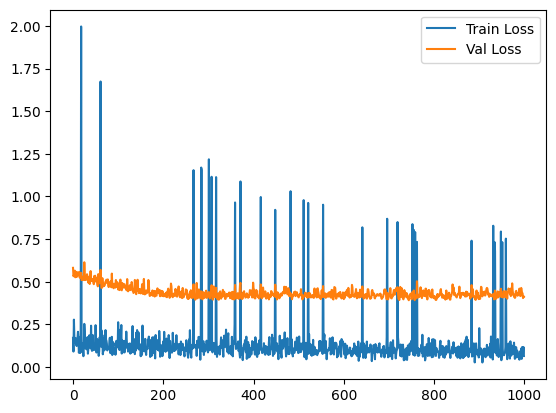

In [94]:
plt.plot(epoch_count, torch.tensor(train_loss_values).numpy(), label='Train Loss')
plt.plot(epoch_count, torch.tensor(val_loss_values).numpy(), label='Val Loss')
plt.legend(['Train Loss', 'Val Loss']) 

In [86]:
x_test = torch.tensor(first_floor_day2_set1_df[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
y_test = torch.tensor(first_floor_day2_set1_df[['abs_dist']].values, dtype=torch.float32).to(device).reshape(-1, 1)
T = 0

In [96]:
modellll = Distance_Spherical()
modellll.load_state_dict(torch.load('/media/hariharan/ULINDU/Ulindu/turtlebot_detection/_BEST MODELS/16-24-48-96-48-24-12-4-1/dist2_uvwh_spherical_set1.pth', map_location=torch.device("cpu")))
modellll.to(device)

t = time()
a=first_floor_day2_set1_df[['u','v','w','h']].apply(lambda x: x/2880).astype(np.float32)
x_test = torch.tensor(first_floor_day2_set1_df[['u','v','w','h','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4']].values, dtype=torch.float32).to(device).reshape(-1, 16)
with torch.inference_mode():  # inference_mode turns off keeping track of the gradients
# disables all the useful things available when training. benifit -> keeps track of less data, faster processing
  y_preds = modellll(x_test)

T += time() - t

print(f"Time taken: {time()-t}")



# mae = torch.mean(torch.abs(y_preds - y_test))*180/math.pi
# std_error = torch.std(torch.abs(y_preds - y_test))*180/math.pi
# print(mae)
# print(std_error)
  
# Calculate error only for true angles between 20 and 160 degrees
# mask = (y_test >= 30*math.pi/180) & (y_test <= 150*math.pi/180)
# print(mask)
# y_test_filtered = y_test[mask]
# y_preds_filtered = y_preds[mask]
# print(y_test_filtered)

# Calculate mean absolute error (MAE) and standard error
mae = torch.mean(torch.abs(y_preds - y_test))
std_error = torch.std(torch.abs(y_preds - y_test))

# Print the results
print("MAE:", mae)
print("Standard Error:", std_error)

Time taken: 0.003751039505004883
MAE: tensor(0.4473)
Standard Error: tensor(0.4195)


In [33]:
y_preds

tensor([[ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 0.9648],
        [ 8.0351],
        [ 7.2938],
        [ 7.0248],
        [ 7.2191],
        [ 7.0159],
        [ 6.9392],
        [ 6.7423],
        [ 6.6602],
        [ 6.3546],
        [ 6.6081],
        [ 6.0204],
        [ 6.0726],
        [ 5.9340],
        [ 5.6398],
        [ 5.4276],
        [ 5.2860],
        [ 5.0108],
        [ 4.8909],
        [ 4.8681],
        [ 4.4683],
        [ 4.2954],
        [ 3.9133],
        [ 3.6345],
        [ 3.4882],
        [ 3.2821],
        [ 3.1713],
        [ 2.9778],
        [ 2.8457],
        [ 2.8070],
        [ 2.6657],
        [ 2.4619],
        [ 2.2905],
        [ 2.1882],
        [ 2.1267],
        [ 2.0672],
        [ 1.9893],
        [ 1.9082],
        [ 1.7444],
        [ 1.5726],
        [ 1.8294],
        [ 1.

In [97]:
T/10

0.0047882795333862305

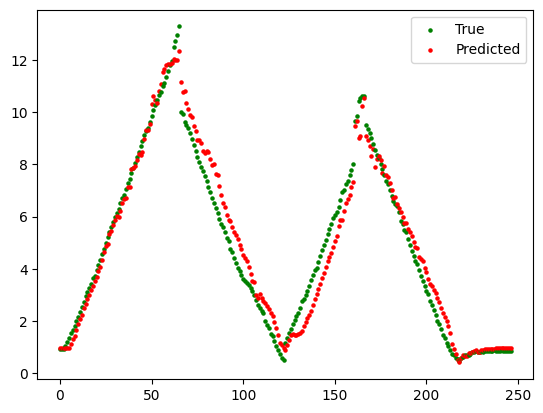

In [103]:
y_test = y_test.cpu().numpy().reshape(-1)
y_preds = y_preds.cpu().numpy().reshape(-1)
for idx in range(len(y_test)):
    plt.scatter(idx, y_test[idx], marker='o', color='g', s=5)
    plt.scatter(idx, y_preds[idx], marker='o', color='r', s=5)

plt.legend(['True', 'Predicted'])

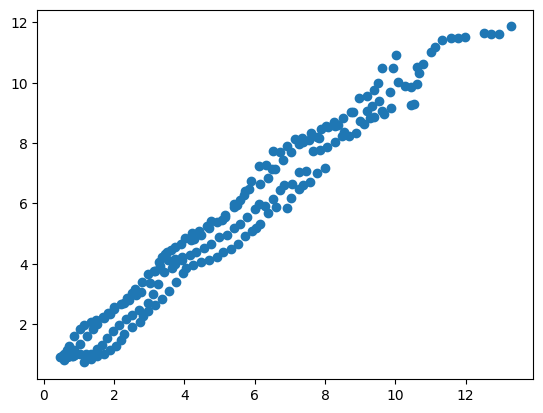

In [212]:
plt.scatter(y_test[:,0].cpu().detach().numpy(), y_preds[:,0].cpu().detach().numpy(), label='Distance')

In [211]:
plt.scatter(y_test[:,1].cpu().detach().numpy(), y_preds[:,1].cpu().detach().numpy(), label='Angle')

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [103]:
torch.save(model.state_dict(), './models/Distance2_2-8-16-32-64-128-64-32-16-8-2_first_floor.pth')

In [4]:
df = pd.read_csv('csv_data/2024-02-20-16-44-.csv') 

In [5]:
df

,filename,robot_in_the_frame_or_not,detected_or_not,abs_dist_gt,abs_dist_pred,angle,angle_pred
0,1708418669.157785_B.jpg,0,0,0.980204,NaN,4.732794,NaN
1,1708418669.217154_F.jpg,1,1,0.980204,1.220729,1.591202,1.720690
2,1708418670.205907_B.jpg,0,0,0.980204,NaN,4.732794,NaN
3,1708418670.345612_F.jpg,1,1,0.980204,1.220627,1.591202,1.720817
4,1708418671.294801_B.jpg,0,0,0.980204,NaN,4.732794,NaN
...,...,...,...,...,...,...,...
896,1708419117.129751_B.jpg,0,0,0.910953,NaN,4.817558,NaN
897,1708419117.158672_F.jpg,1,1,0.910953,1.190975,1.675966,1.672795
898,1708419118.152508_B.jpg,0,0,0.910953,NaN,4.817558,NaN
899,1708419118.174965_F.jpg,1,1,0.910953,1.190847,1.675966,1.672977


In [210]:
error = 0
count = 0
for idx, row in df.iterrows():
    if row['robot_in_the_frame_or_not'] == 1 and row['detected_or_not'] == 1 and row['angle'] <= math.pi:
        plt.scatter(idx, row['angle']*180/math.pi, marker='o', color='g', s=5)
        plt.scatter(idx, row['angle_pred']*180/math.pi, marker='o', color='r', s=5)
        error += abs(row['angle']*180/math.pi - row['angle_pred']*180/math.pi)
        count += 1

print(f"MAE : {error/count} degrees")

plt.xlabel('Image Number')
plt.ylabel('Angle')
plt.title('Angle vs Image Number')
plt.legend(['True Angle', 'Predicted Angle'])


NameError: name 'df' is not defined

MAE : 4.865595365119669 degrees


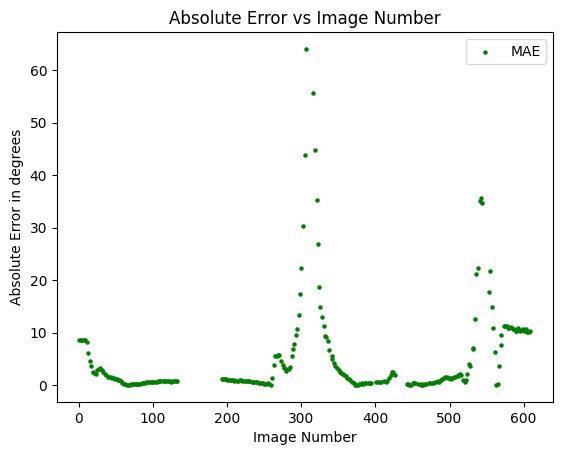

In [30]:
error = 0
count = 0
for idx, row in df.iterrows():
    if row['robot_in_the_frame_or_not'] == 1 and row['detected_or_not'] == 1 and row['angle'] <= math.pi:
        plt.scatter(idx, abs(row['angle']*180/math.pi-row['angle_pred']*180/math.pi), marker='o', color='g', s=5)
        # plt.scatter(idx, row['angle_pred']*180/math.pi, marker='o', color='r', s=5)
        error += abs(row['angle'] - row['angle_pred'])
        count += 1

print(f"MAE : {error*180/(math.pi*count)} degrees")

plt.xlabel('Image Number')
plt.ylabel('Absolute Error in degrees')
plt.title('Absolute Error vs Image Number')
plt.legend(['MAE'])


MAE : 0.5451114943596405 m


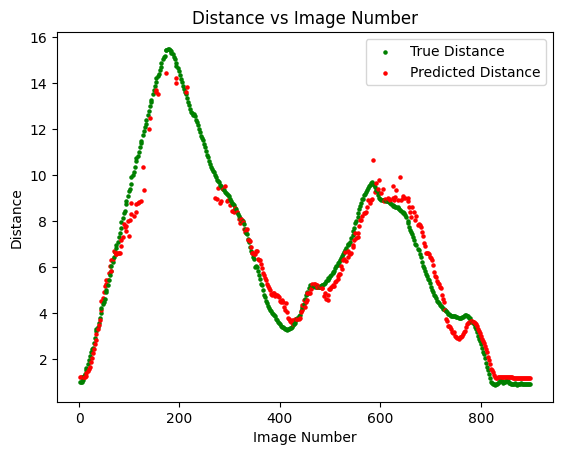

In [7]:
error_dist = 0
count = 0
for idx, row in df.iterrows():
    if row['robot_in_the_frame_or_not'] == 1:
        plt.scatter(idx, row['abs_dist_gt'], marker='o', color='g', s=5)
        if row['detected_or_not'] == 1:
            error_dist += abs(row['abs_dist_gt'] - row['abs_dist_pred'])
            count += 1
            plt.scatter(idx, row['abs_dist_pred'], marker='o', color='r', s=5)

print(f"MAE : {error_dist/count} m")
plt.xlabel('Image Number')
plt.ylabel('Distance')
plt.title('Distance vs Image Number')
plt.legend(['True Distance', 'Predicted Distance'])


Text(0.5, 1.0, 'True Perpendicular Distance vs Predicted Perpendicular Distance')

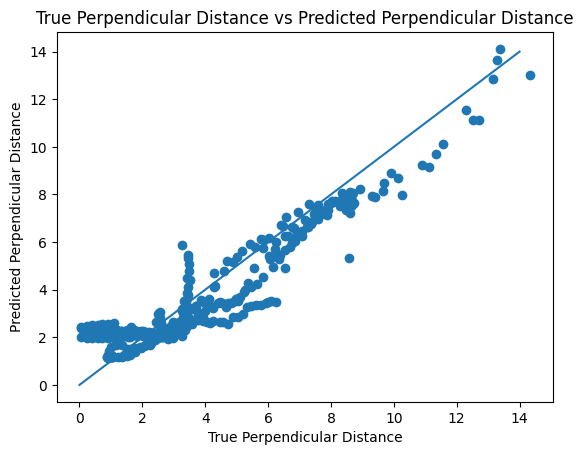

In [116]:
plt.scatter(df['perp_dist_to_the_robot_gt'], df['perp_dist_to_the_robot_pred'])
plt.xlabel('True Perpendicular Distance')
plt.ylabel('Predicted Perpendicular Distance')

# Generate x values
x = np.linspace(0, 14, 100)

# Calculate corresponding y values
y = x

# Plot the function
plt.plot(x, y)

plt.title('True Perpendicular Distance vs Predicted Perpendicular Distance')

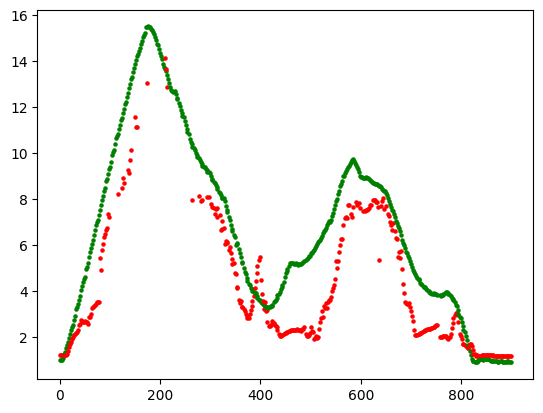

In [108]:
for idx, row in df.iterrows():
    if row['robot_in_the_frame_or_not'] == 1:
        plt.scatter(idx, row['dist_to_the_robot_gt'], marker='o', color='g', s=5)
        if row['detected_or_not'] == 1:
            plt.scatter(idx, row['perp_dist_to_the_robot_pred'], marker='o', color='r', s=5)

In [80]:
df_2 = pd.read_csv('./csv_data/output_dataframes/2024-02-20-16-44-28_first_floor_output_dataframe.csv')

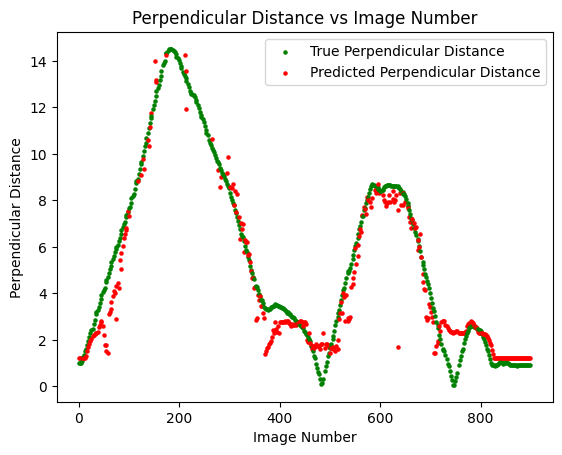

In [151]:
for idx, row in df_2.iterrows():
    if row['robot_in_the_frame_or_not'] == 1:
        plt.scatter(idx, row['perp_dist_to_the_robot_gt'], marker='o', color='g', s=5)
        if row['detected_or_not'] == 1:
            plt.scatter(idx, row['perp_dist_to_the_robot_pred'], marker='o', color='r', s=5)

plt.title('Perpendicular Distance vs Image Number')
plt.xlabel('Image Number')
plt.ylabel('Perpendicular Distance')
plt.legend(['True Perpendicular Distance', 'Predicted Perpendicular Distance'])

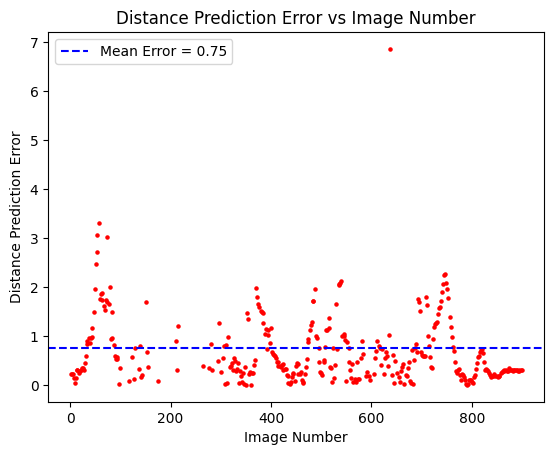

In [162]:
for idx, row in df_2.iterrows():
    if row['robot_in_the_frame_or_not'] == 1:
        # plt.scatter(idx, row['perp_dist_to_the_robot_gt'], marker='o', color='g', s=5)
        # plt.scatter(idx, row['angle'], marker='o', color='b', s=5)
        if row['detected_or_not'] == 1:
            # plt.scatter(idx, row['perp_dist_to_the_robot_pred'], marker='o', color='r', s=5)
            plt.scatter(idx, abs(row['perp_dist_to_the_robot_gt']-row['perp_dist_to_the_robot_pred']), marker='o', color='r', s=5)

plt.title('Distance Prediction Error vs Image Number')
plt.xlabel('Image Number')
plt.ylabel('Distance Prediction Error')
plt.axhline(y=abs(df_2['perp_dist_to_the_robot_gt']-df_2['perp_dist_to_the_robot_pred']).mean(), color='b', linestyle='--',label=f'Mean Error = {abs(df_2["perp_dist_to_the_robot_gt"]-df_2["perp_dist_to_the_robot_pred"]).mean():.2f}')
plt.legend()

 